In [66]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
from pathlib import Path

In [74]:
server_round = 4 # starts at
experiment ="2023-01-06_101255"

In [79]:
path_to_stats_root = Path(f"/home/pedro/flwr_monitor/{experiment}/{server_round}/")
nodes = [x.parts[-1] for x in path_to_stats_root.glob("*") if x.is_dir()]

# Load Data

## Resources

In [80]:
resources = {}
for node_id in nodes:
	resources[node_id] = {}
	path_to_stats = path_to_stats_root / node_id
	for hw in ["cpu", "gpus"]:
		with open(path_to_stats / "resources" / f"{hw}.pickle", "rb") as f:
			resources[node_id][hw] = pickle.load(f)

## Tasks

In [81]:
tasks = {}
for node_id in nodes:
    tasks[node_id] = {}
    path_to_stats = path_to_stats_root / node_id
    for task_file in (path_to_stats / "tasks").glob("**/*.pickle"):
        with open(task_file, "rb") as f:
            task = pickle.load(f)
            tasks[node_id][task.id] = task

# Plot System Utilization

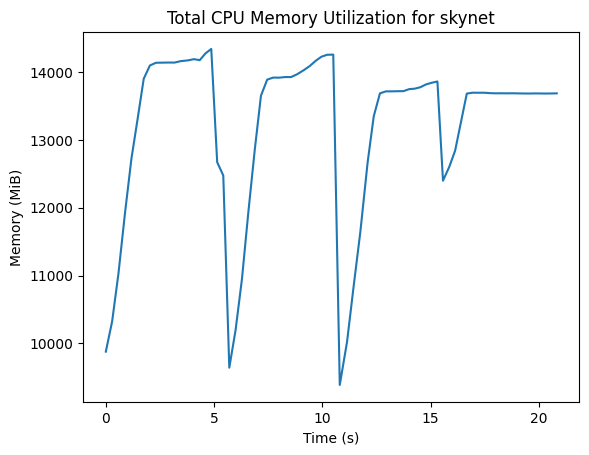

In [103]:
fig = plt.figure()
for idx, node_id in enumerate(nodes, start=1):
    ax = fig.add_subplot(len(nodes),1,idx)
    x_y = resources[node_id]["cpu"].all_proc_mem_used_mb
    x = np.array([a[0] for a in x_y])/1e9
    x = x -x[0]
    y = np.array([a[1] for a in x_y])/1024/1024
    ax.plot(x,y)
    ax.set(xlabel="Time (s)", ylabel="Memory (MiB)",title=f"Total CPU Memory Utilization for {node_id}")

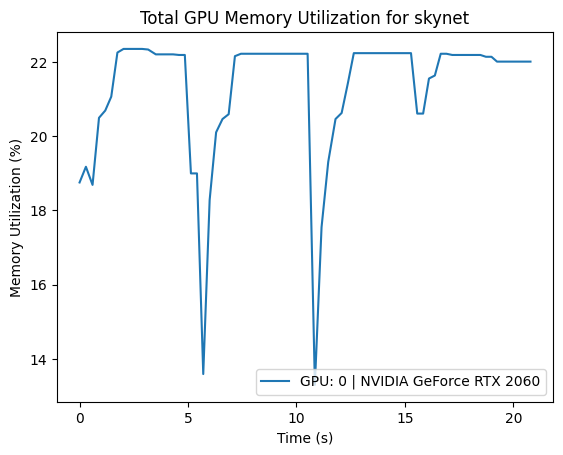

In [102]:
fig = plt.figure()
for idx, node_id in enumerate(nodes, start=1):
    for k,v in resources[node_id]["gpus"].items():
        ax = fig.add_subplot(len(nodes),1,idx)
        t = v.total_mem_mb
        x = np.array([a[0] for a in v.all_proc_mem_used_mb])/1e9
        x = x - x[0]
        y = [a[1]*100/t for a in v.all_proc_mem_used_mb] 
        ax.plot(x,y)
        ax.set(xlabel="Time (s)", ylabel="Memory Utilization (%)",
            title=f"Total GPU Memory Utilization for {node_id}")
        ax.legend([f"GPU: {v.gpu_id} | {v.name}"])

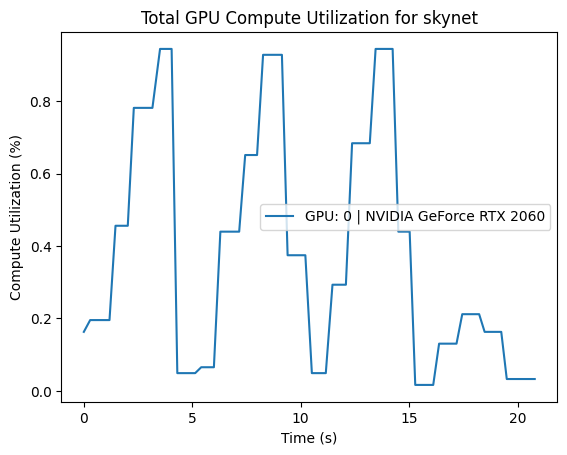

In [104]:
fig = plt.figure()
for idx, node_id in enumerate(nodes, start=1):
    for k,v in resources[node_id]["gpus"].items():
        ax = fig.add_subplot(len(nodes),1,idx)
        t = v.total_mem_mb
        x = np.array([a[0] for a in v.utilization])/1e9
        x = x - x[0]
        y = [a[1]*100/t for a in v.utilization] 
        ax.plot(x,y)
        ax.set(xlabel="Time (s)", ylabel="Compute Utilization (%)",
            title=f"Total GPU Compute Utilization for {node_id}")
        ax.legend([f"GPU: {v.gpu_id} | {v.name}"])

### Tasks Resource Requirements

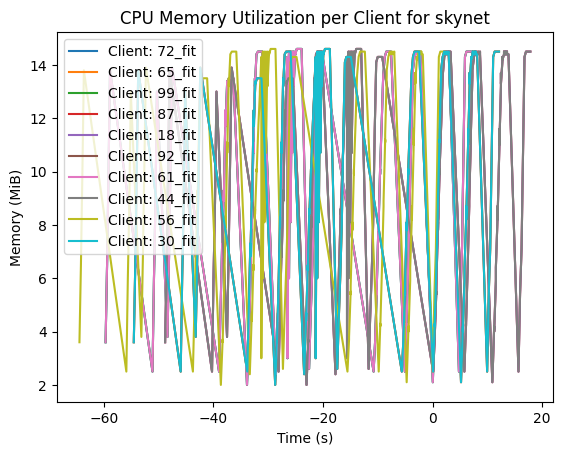

In [93]:
fig = plt.figure()
legends = []
for idx, node_id in enumerate(nodes, start=1):
    ax = fig.add_subplot(len(nodes),1,idx)
    for k, task in tasks[node_id].items():
        start_time = task.start_time_ns
        x = np.array([a[0] -start_time for a in task.cpu_process.this_proc_mem_used_mb])/1e9
        y = np.array([a[1] for a in task.cpu_process.this_proc_mem_used_mb])
        ax.plot(x,y)
        legends.append(f"Client: {task.task_name}")
    ax.legend(legends)
    ax.set(title=f"CPU Memory Utilization per Client for {node_id}", xlabel="Time (s)", ylabel="Memory (MiB)")


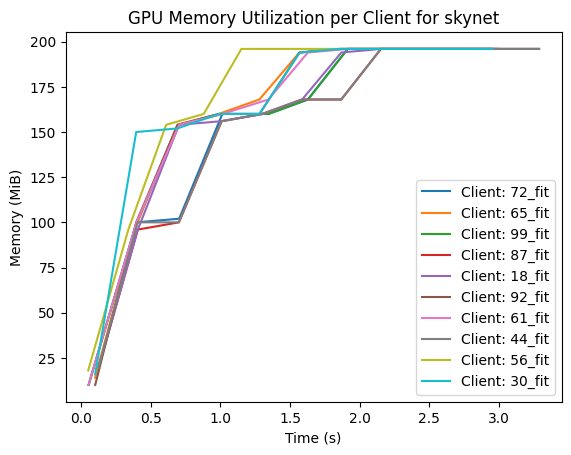

In [97]:
fig = plt.figure()
for idx, node_id in enumerate(nodes, start=1):
    ax = fig.add_subplot(len(nodes),1,idx)
    legends = []
    for k, task in tasks[node_id].items():
        start_time = task.start_time_ns
        for gpu_uuid, gpu_process in task.gpu_processes.items():
            x = np.array([a[0]-start_time for a in gpu_process.this_proc_mem_used_mb])/1e9
            y = np.array([a[1] for a in gpu_process.this_proc_mem_used_mb])
            ax.plot(x,y)
            legends.append(f"Client: {task.task_name}")
    ax.legend(legends)
    ax.set(title=f"GPU Memory Utilization per Client for {node_id}", xlabel="Time (s)", ylabel="Memory (MiB)")
